# 1. Setup

In [1]:
# TODO: clean this up
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as notebook_tqdm
import re
import string
import nltk
import torch
import transformers as ppb
from nltk import pos_tag, download
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from math import ceil
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.naive_bayes import MultinomialNB

In [2]:
# Load the dataset from the Hugging Face Hub
notebook_tqdm.tqdm.pandas()
dataset = load_dataset('ucberkeley-dlab/measuring-hate-speech')

# Convert the dataset to a pandas DataFrame
df_raw = dataset['train'].to_pandas()

In [3]:
TRAIN_RATIO = 0.8 # TODO: factor this out everywhere
TEST_RATIO = 1 - TRAIN_RATIO
HATE_SPEECH_THRESHOLD_UNNORMALIZED = 0.5
SUPPORTIVE_THRESHOLD_UNNORMALIZED = -1
EVALUATION_METRICS = ['precision', 'recall', 'f1-score']


In [4]:
results = []

# 2. Filtering & EDA

### 2.0. Function definitions & variables

In [5]:
def plot_hate_speech_score_histogram(df: pd.DataFrame, hate_threshold: float, supportive_threshold: float):
    """
    Plots a histogram of the hate_speech_score with annotated lines at the thresholds

    Args:
        df (pd.DataFrame): The dataframe to plot the histogram from
        hate_threshold (float): The threshold for hate speech
        supportive_threshold (float): The threshold for supportive speech

    Returns:
        None (plots the histogram)
    """

    total_count = df.shape[0]
    
    # Calculate the amount of values below the supportive threshold
    supportive_count = df[df['hate_speech_score'] < supportive_threshold].shape[0]

    # Calculate the amount of values above the hate threshold
    hate_count = df[df['hate_speech_score'] > hate_threshold].shape[0]

    # Calculate the amount of values between the thresholds
    neutral_count = df[(df['hate_speech_score'] >= supportive_threshold) & (df['hate_speech_score'] <= hate_threshold)].shape[0]

    print(f"Total count: {total_count}")
    print(f"Supportive count: {supportive_count} ({supportive_count / total_count * 100:.2f}%)")
    print(f"Hate count: {hate_count} ({hate_count / total_count * 100:.2f}%)")
    print(f"Neutral count: {neutral_count} ({neutral_count / total_count * 100:.2f}%)")

    # Plot in histogram as well
    plt.hist(df['hate_speech_score'], bins=100)
    plt.axvline(hate_threshold, color='red', linestyle='--', label='Hate Speech Threshold')
    plt.axvline(supportive_threshold, color='blue', linestyle='--', label='Supportive Threshold')
    plt.legend()
    plt.show()

def plot_target_columns_distribution(df: pd.DataFrame, target_cols: list[str]):
    """
    Plots a barchart of the average value of the target columns for the hate speech observations

    Args:
        df (pd.DataFrame): The dataframe to plot the distribution from
        target_cols (list[str]): The columns to plot

    Returns:
        None (plots the distribution)
    """

    # Filter to count hate speech only
    hate_speech_df = df[df['is_hate_speech'] == 1]

    # Calculate the mean value of the target columns for the hate speech observations and sort them descending
    mean_values = hate_speech_df[target_cols].mean()
    mean_values = mean_values.sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    mean_values.plot(kind='bar')
    plt.title('Percentage of hate speech columns targeting a specific group')
    plt.xlabel('Target Column')
    plt.ylabel('Percentage of hate speech')
    plt.show()

def plot_target_columns_detailed(df: pd.DataFrame, target_cols: list[str], fig_size: tuple[int, int] = (15, 30), y_max: float = 0.35):
    """
    Plots a bar chart for each of the target columns with detailed breakdowns of sub-groups

    Args:
        df (pd.DataFrame): The dataframe to plot the distribution from
        target_cols (list[str]): The columns to plot

    Returns:
        None (plots the distributions)

    """

    # Filter to count hate speech only
    hate_speech_df = df[df['is_hate_speech'] == 1]

    # initalize axes to plot the 7 sub-groups in two rows of 3 and a last row of 1
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=fig_size)
    # For each of the target columns, make a list of means of of hate speach targeting its sub-groups
    for ax, col in zip(axes.flatten(), target_cols):

        # Calculate the number of observations with a non-zero value for the target column
        non_zero_count = hate_speech_df[col].value_counts()[1]

        # identify all columns in the dataframe that starts with the target column name
        sub_groups_column_names = [column for column in df.columns if column.startswith(col)]

        # remove the original target column from the list
        sub_groups_column_names.remove(col)
        col_name = col.replace("target_", "").title()

        # calculate the mean values for each sub-group
        sub_group_means = hate_speech_df[sub_groups_column_names].mean()
        sub_group_means = sub_group_means.sort_values(ascending=False)

        # remove the col string from the labels
        labels = sub_group_means.index.str.replace((col + "_"), '')

        # plot on the specific axis
        sub_group_means.plot(kind='bar', ax=ax)
        ax.set_xticklabels(labels)
        ax.set_title(f'Percentage of hate speech targeting {col_name} by sub-group \n(n={non_zero_count})')
        ax.set_xlabel('Sub-group')
        ax.set_ylabel('Percentage of hate speech')
        ax.set_ylim(0, y_max)
    
    plt.subplots_adjust(hspace=0.7)

def inspect_for_cor(df, columns: list[str], plot_label: str, hate_speech_only: bool = True):

    # filter for hate speech only if specified
    if hate_speech_only:
        df = df[df['is_hate_speech'] == 1]
    
    # Make a correlation matrix
    corr_matrix = df[columns].corr()

    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap for {plot_label}')
    plt.show()

    # Make a pairplot of the columns
    sns.pairplot(df[columns])
    plt.title(f'Pairplot for {plot_label}')
    plt.show()


In [6]:
aspect_cols = [
    'insult',
    'humiliate',
    'status',
    'dehumanize',
    'violence',
    'genocide'
]

target_cols_lvl1_and_2 = [col for col in df_raw.columns if col.startswith('target_')]

target_cols_lvl1 = [
    'target_race',
    'target_religion',
    'target_origin',
    'target_gender',
    'target_sexuality',
    'target_age',
    'target_disability',    
]

cols_to_keep = [
    'comment_id', 
    'text', 
    'hate_speech_score',
    *aspect_cols,
    *target_cols_lvl1_and_2
]


### 2.1. Pre-filtering EDA

Total count: 135556
Supportive count: 53651 (39.58%)
Hate count: 49048 (36.18%)
Neutral count: 32857 (24.24%)


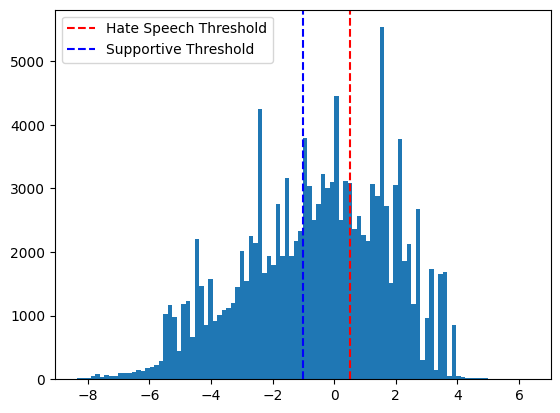

In [7]:
plot_hate_speech_score_histogram(df_raw, HATE_SPEECH_THRESHOLD_UNNORMALIZED, SUPPORTIVE_THRESHOLD_UNNORMALIZED)

### 2.2. Filtering & reformating

TODO: Make list of filtering actions for report 


In [8]:
# Check for duplicate rows based on the 'comment_id' column
duplicate_texts = df_raw[df_raw.duplicated(subset='comment_id', keep=False)]
print(f"Number of duplicate texts: {duplicate_texts.shape[0]}")
duplicate_texts[['comment_id', 'text']].head()

Number of duplicate texts: 125479


,comment_id,text
0,47777,Yes indeed. She sort of reminds me of the elde...
1,39773,The trans women reading this tweet right now i...
2,47101,Question: These 4 broads who criticize America...
3,43625,It is about time for all illegals to go back t...
4,12538,For starters bend over the one in pink and kic...


In [9]:
# Group by 'comment_id' and count unique 'hate_speech_score' values per group
score_check = df_raw.groupby("comment_id")["hate_speech_score"].nunique()

# Find texts with more than one unique score
inconsistent = score_check[score_check > 1]

# Show how many inconsistencies there are
print(f"Number of 'comment_id' entries with inconsistent scores: {len(inconsistent)}")

# Optionally, view a few examples
if not inconsistent.empty:
    print(df_raw[df_raw["comment_id"].isin(inconsistent.index)].sort_values("comment_id").head(10))

Number of 'comment_id' entries with inconsistent scores: 0


In [10]:
# Step 1: Select relevant columns
df_relevant = df_raw[cols_to_keep].copy()

# Step 2: Convert booleans to integers for mean calculation
bool_cols = [col for col in df_relevant.columns if col.startswith('target_')]
df_relevant[bool_cols] = df_relevant[bool_cols].astype(int)

# Step 3: Group by 'comment_id' and 'text' to keep them in final output
filtered_df = df_relevant.groupby(['comment_id', 'text']).mean().reset_index()

In [11]:
min_score = filtered_df['hate_speech_score'].min()  # e.g., -8.34
max_score = filtered_df['hate_speech_score'].max()  # e.g., +6.3

# replace hate speech core column with normalized column - [0, 1]
filtered_df['hate_speech_score'] = (filtered_df['hate_speech_score'] - min_score) / (max_score - min_score)


In [12]:
# Normalize the thresholds given by the dataset authors
HATE_SPEECH_THRESHOLD_NORMALIZED = (0.5 - min_score) / (max_score - min_score)  
SUPPORTIVE_THRESHOLD_NORMALIZED = (-1 - min_score) / (max_score - min_score)

# Add binary columns for hate speech
filtered_df.insert(filtered_df.columns.get_loc('hate_speech_score') + 1, 'is_hate_speech', (filtered_df['hate_speech_score'] > HATE_SPEECH_THRESHOLD_NORMALIZED).astype(int))

# Print new normalized thresholds 
print(f"Threshold for hate speech: {HATE_SPEECH_THRESHOLD_NORMALIZED:.3f} -> Equivalent to {0.5} on the original scale")
print(f"Threshold for counter speech: {SUPPORTIVE_THRESHOLD_NORMALIZED:.3f} -> Equivalent to {-1} on the original scale")
print(f"Between the two thresholds: {HATE_SPEECH_THRESHOLD_NORMALIZED:.3f} and {SUPPORTIVE_THRESHOLD_NORMALIZED:.3f} -> Equivalent to {0.5} and {-1} on the original scale which is the unambiguous region")


Threshold for hate speech: 0.604 -> Equivalent to 0.5 on the original scale
Threshold for counter speech: 0.501 -> Equivalent to -1 on the original scale
Between the two thresholds: 0.604 and 0.501 -> Equivalent to 0.5 and -1 on the original scale which is the unambiguous region


In [13]:
filtered_df.describe()

,comment_id,hate_speech_score,is_hate_speech,insult,humiliate,status,dehumanize,violence,genocide,target_race_asian,...,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability
count,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,...,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000
mean,25064.175028,0.505197,0.261696,2.451707,2.170926,2.560852,1.700071,0.825427,0.448814,0.036070,...,0.001216,0.024744,0.002986,0.013872,0.006091,0.001186,0.001254,0.006339,0.002392,0.025676
std,14573.790336,0.141604,0.439563,1.185507,1.147433,0.699245,1.098025,1.000165,0.765847,0.161093,...,0.028330,0.137500,0.046627,0.105851,0.068472,0.029225,0.030446,0.068151,0.041602,0.146039
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12336.000000,0.410519,0.000000,1.666667,1.333333,2.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24986.000000,0.521858,0.000000,3.000000,2.333333,2.500000,1.666667,0.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37837.000000,0.608607,1.000000,3.333333,3.000000,3.000000,2.500000,1.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,50070.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39565 entries, 0 to 39564
Data columns (total 63 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   comment_id                             39565 non-null  int32  
 1   text                                   39565 non-null  object 
 2   hate_speech_score                      39565 non-null  float64
 3   is_hate_speech                         39565 non-null  int64  
 4   insult                                 39565 non-null  float64
 5   humiliate                              39565 non-null  float64
 6   status                                 39565 non-null  float64
 7   dehumanize                             39565 non-null  float64
 8   violence                               39565 non-null  float64
 9   genocide                               39565 non-null  float64
 10  target_race_asian                      39565 non-null  float64
 11  ta

In [15]:
from sklearn.utils import resample

filtered_df = filtered_df.copy()

# 2) Split into majority / minority
df_majority = filtered_df[filtered_df.is_hate_speech == 0]
df_minority = filtered_df[filtered_df.is_hate_speech == 1]

# 3) Down‐sample majority to match minority
df_majority_down = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority),
    random_state=42
)

# 4) Overwrite filtered_df with the balanced combination
filtered_df = pd.concat([df_minority, df_majority_down]) \
                  .sample(frac=1, random_state=42) \
                  .reset_index(drop=True)

# (Optional) verify
print(filtered_df.is_hate_speech.value_counts(normalize=True))

is_hate_speech
0    0.5
1    0.5
Name: proportion, dtype: float64


### 2.3. Post-filtering EDA

Total count: 20708
Supportive count: 6190 (29.89%)
Hate count: 10354 (50.00%)
Neutral count: 4164 (20.11%)


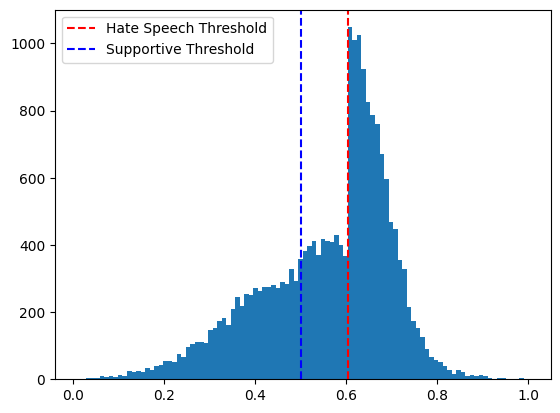

In [16]:
plot_hate_speech_score_histogram(filtered_df, HATE_SPEECH_THRESHOLD_NORMALIZED, SUPPORTIVE_THRESHOLD_NORMALIZED)

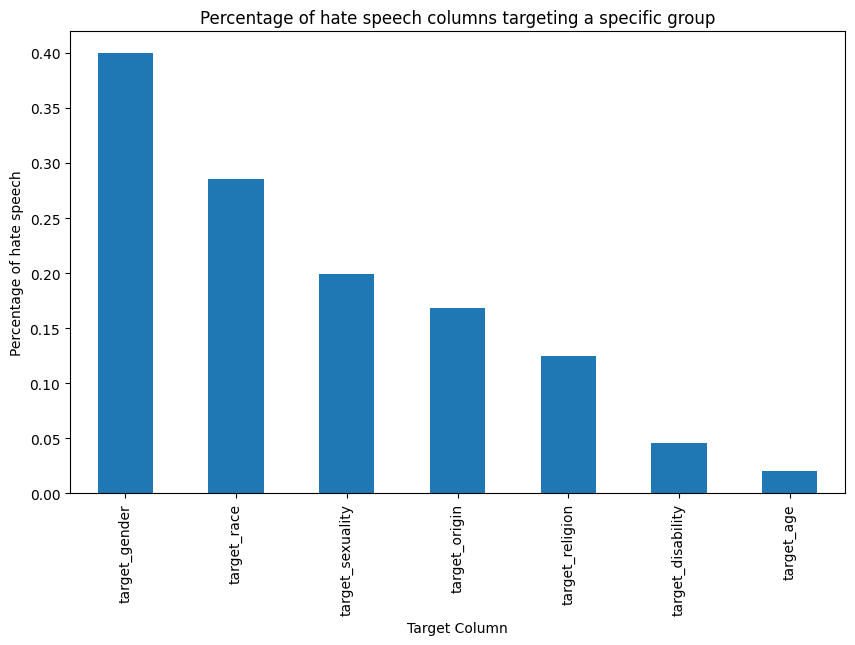

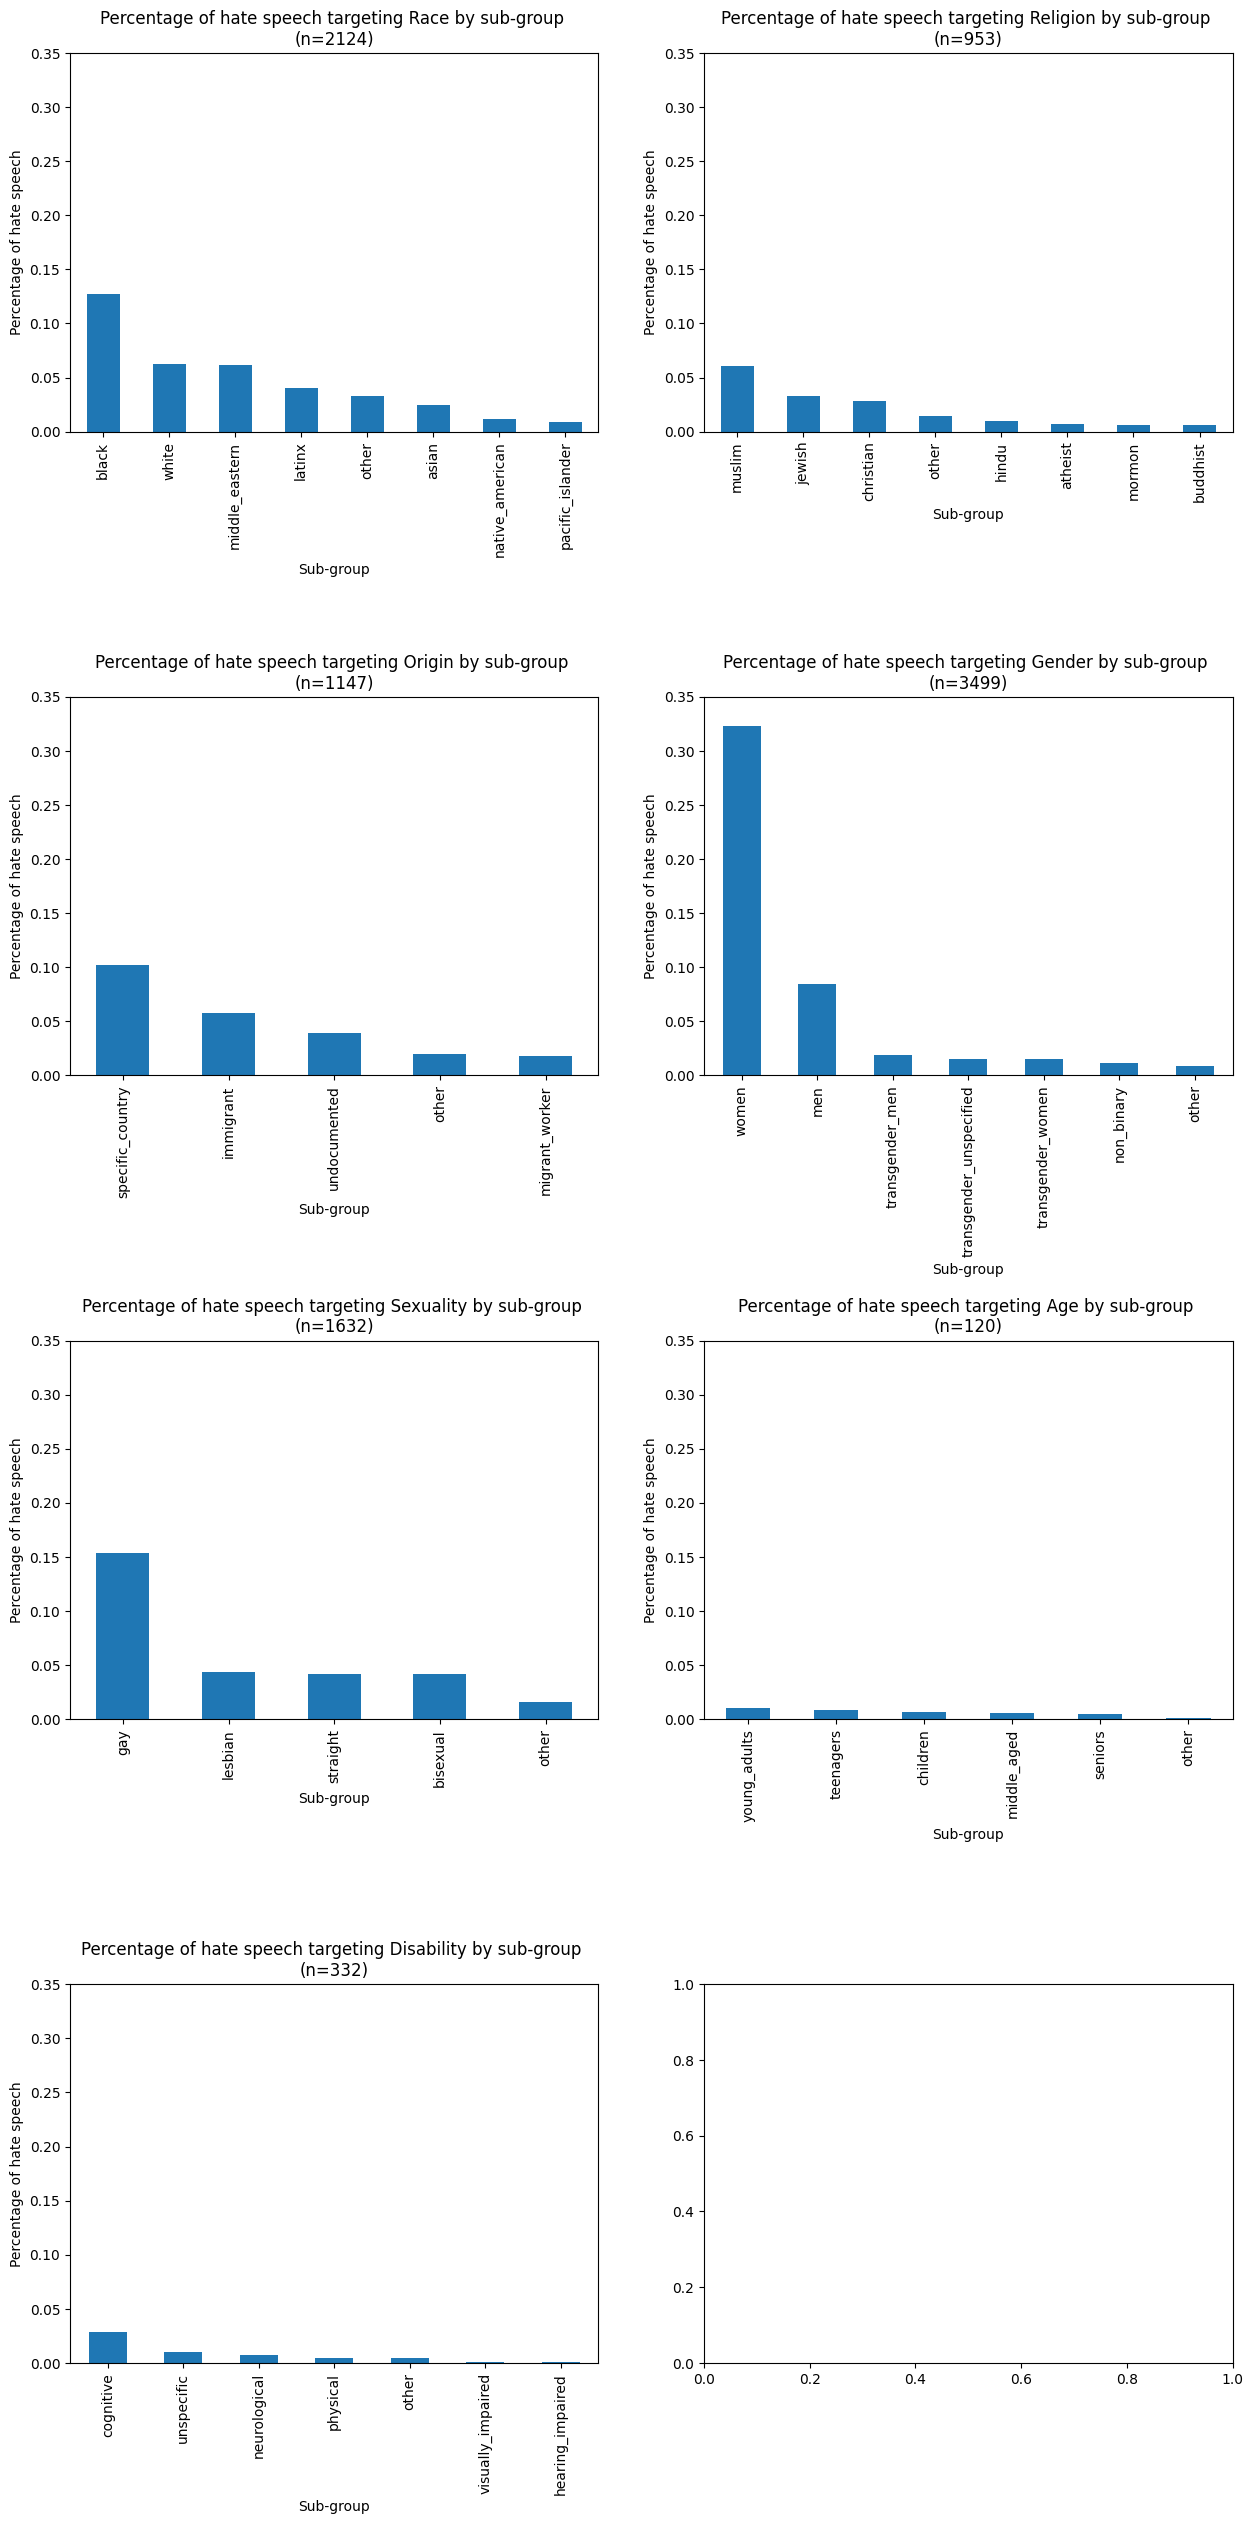

In [17]:
plot_target_columns_distribution(filtered_df, target_cols_lvl1)
plot_target_columns_detailed(filtered_df, target_cols_lvl1)

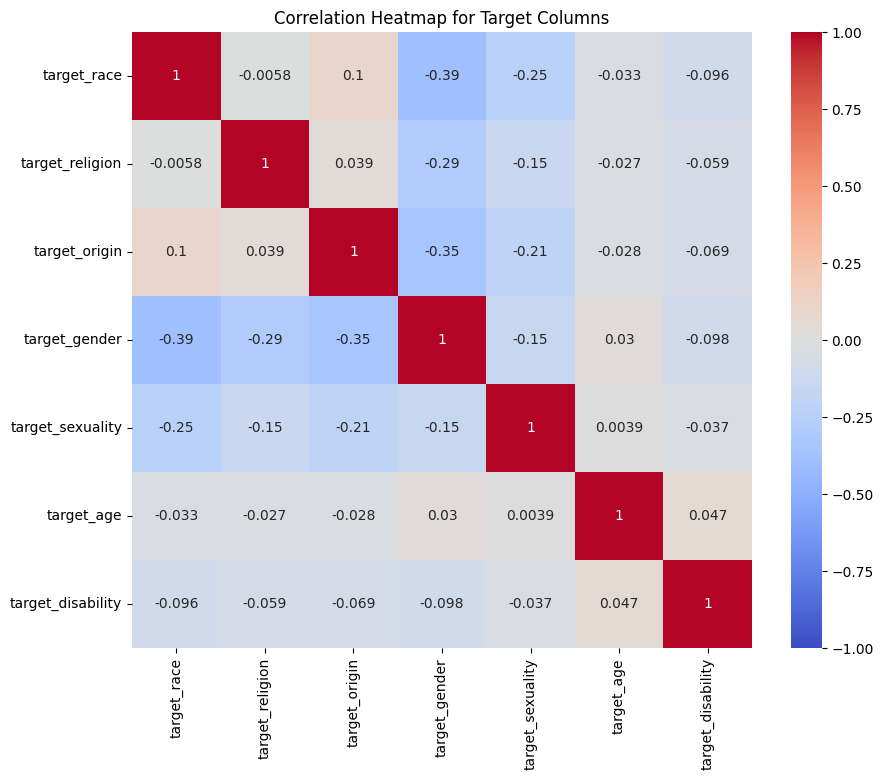

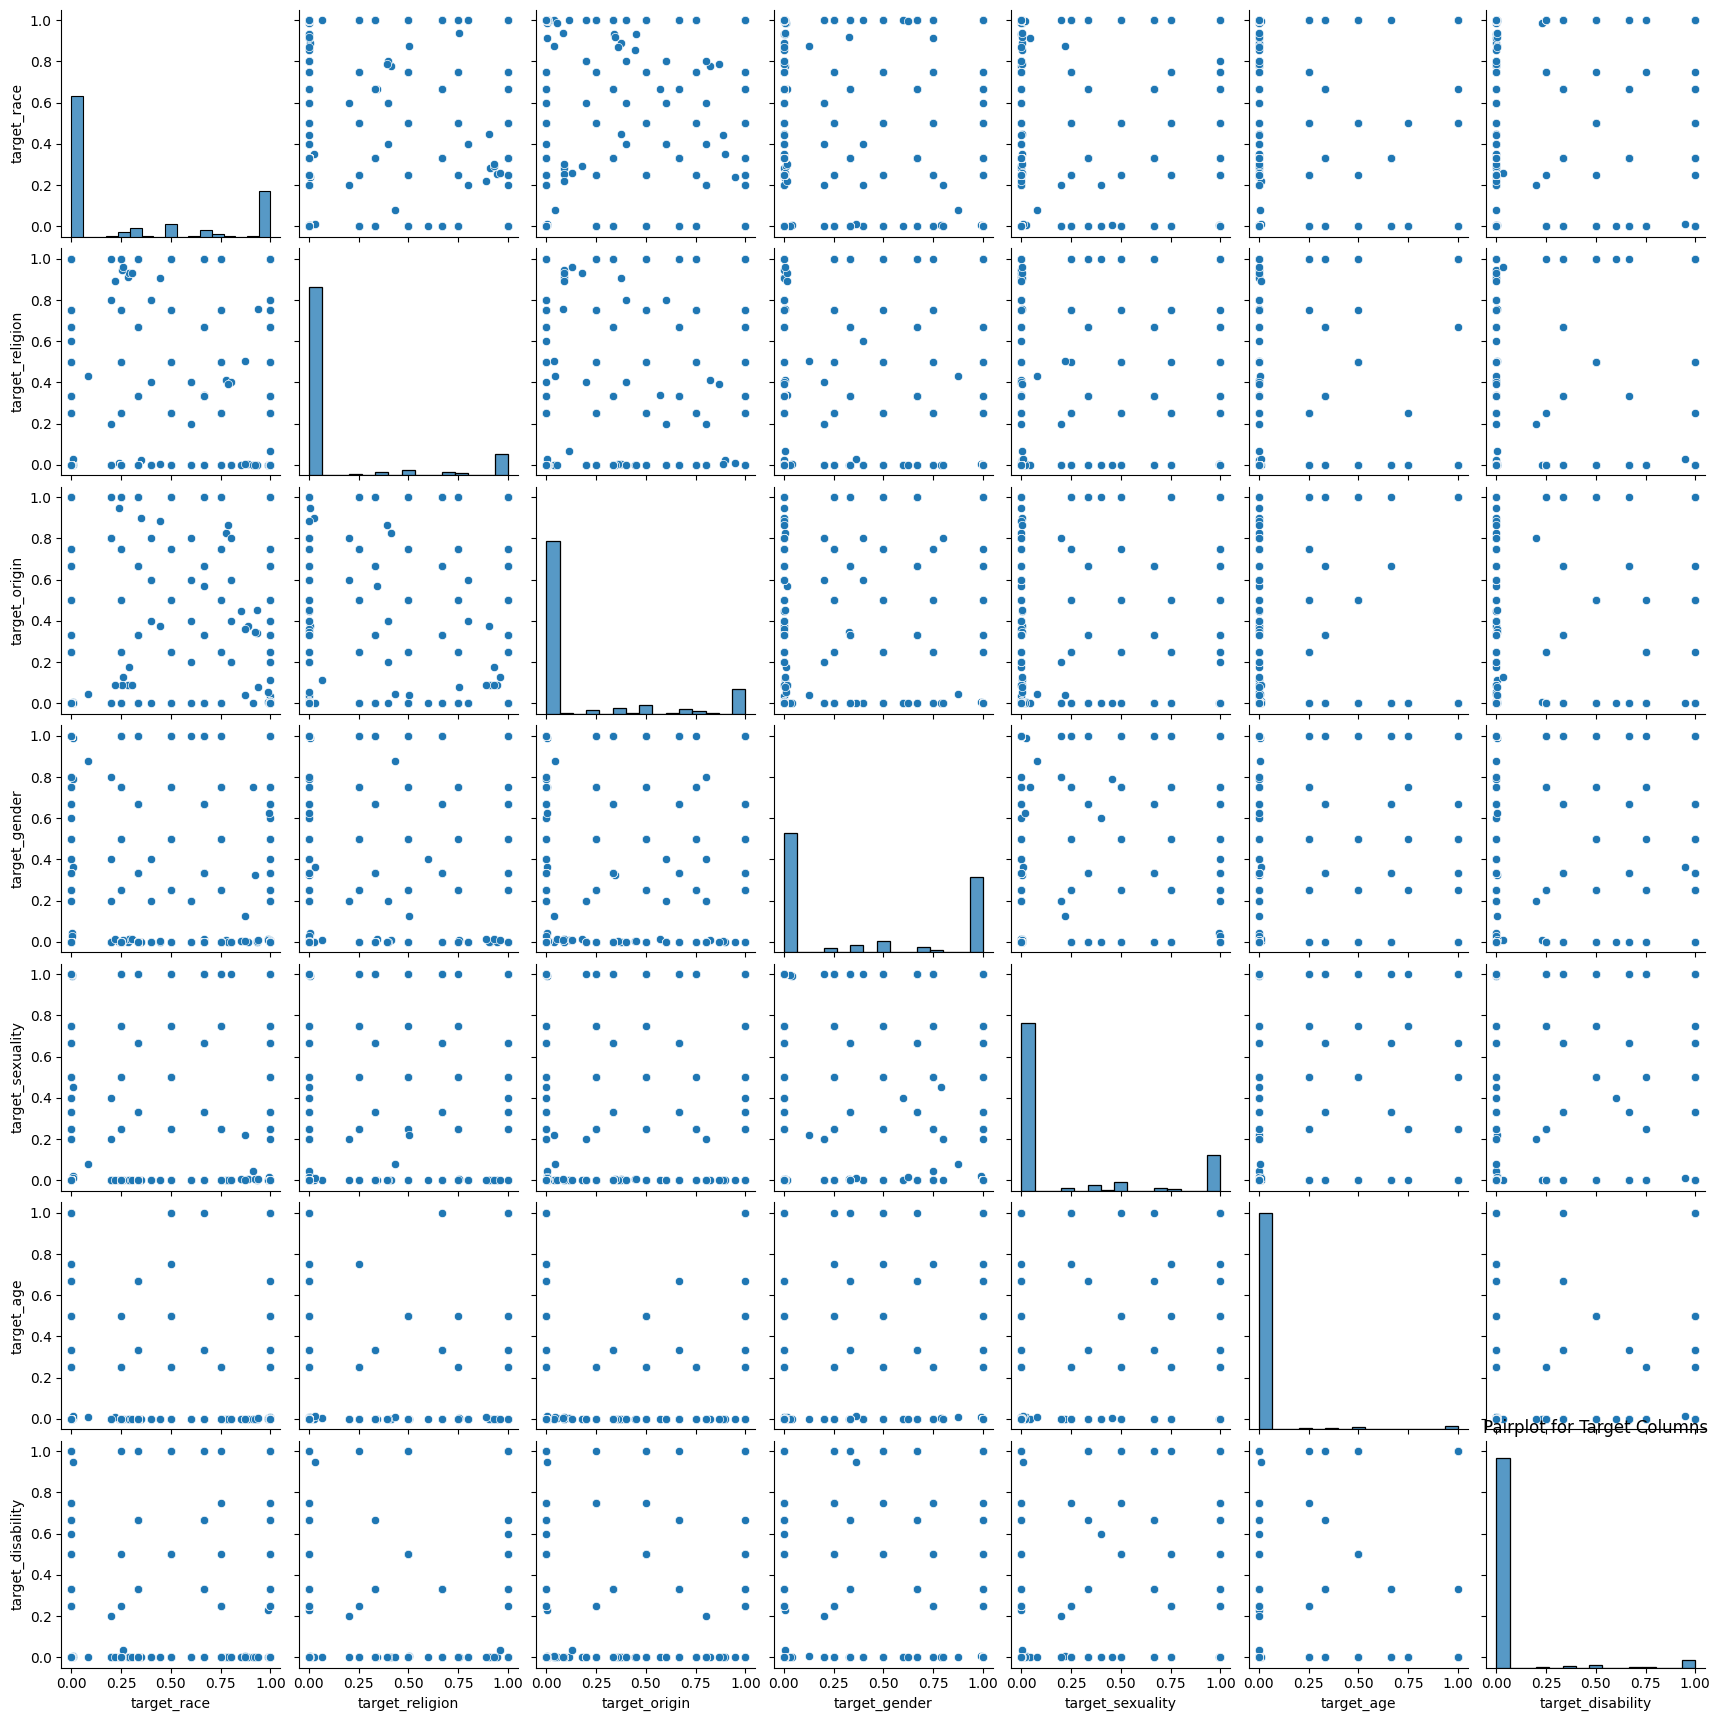

In [18]:
inspect_for_cor(filtered_df, target_cols_lvl1, 'Target Columns')

# 3. Models

### 3.0 Function & Class definitions

In [19]:
# Download necessary NLTK resources
for resource in ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger_eng']:
    nltk.download(resource, quiet=True)

# Tokenizer
tknzr = TweetTokenizer()
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [20]:
def append_results(results: list, report: dict, model_name: str, metrics: list[str]):
    
    append_dict = {}

    for metric in metrics:
        append_dict[f'{metric}_hate'] = report['1'][metric]
        append_dict[f'{metric}_non_hate'] = report['0'][metric]
        append_dict[f'{metric}_macro_avg'] = report['macro avg'][metric]
        append_dict[f'{metric}_weighted_avg'] = report['weighted avg'][metric]

    append_dict['accuracy'] = report['accuracy']

    results.append({
        'model': model_name,
        **append_dict
    })

def get_wordnet_pos(tag):
    """
    Convert the part of speech tag to a format that WordNet lemmatizer can understand.
    starts with 'J' for adjectives, 'V' for verbs, 'N' for nouns, and 'R' for adverbs.
    Args:
        tag (str): The part of speech tag.
    Returns:
        str: The WordNet part of speech tag.
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def is_ascii(token):
    return all(ord(c) < 128 for c in token)

def remove_repeated_chars(token, threshold=3):
    return re.sub(r'(.)\1{' + str(threshold) + r',}', r'\1', token)

def bow_preprocess(text):
    """
    Preprocess the text by tokenizing, removing punctuation, stop words,
    and lemmatizing the words.
    Args:
        text (str): The text to preprocess.
    Returns:
        str: The preprocessed text.
    Example:
        >>> preprocess("This is an EXAMPLE sentence!!!.")
        'example sentence'
        
    """
    tokens = tknzr.tokenize(text) # Tokenize the text
    tokens = [word.lower() for word in tokens if word not in string.punctuation] # Remove punctuation
    tokens = [word for word in tokens if word not in stop_words] # Remove stop words
    tokens = [remove_repeated_chars(word) for word in tokens] # Remove repeated characters, ex: "loooove" -> "love"
    tokens = [word for word in tokens if len(word) >= 2 and is_ascii(word)]  # Filter by length and ASCII
    pos_tags = pos_tag(tokens) # Get part of speech tags
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags] # Lemmatize the words using the part of speech tags
    return " ".join(lemmatized)

def stream_batches(texts, labels, batch_size=32, max_length=256):
    """
    Streams batches into SGD classifier

    Args:
        texts (pd.Series): The texts to stream
        labels (pd.Series): The labels to stream
        batch_size (int): The batch size
        max_length (int): The maximum length of the texts
    
    Returns:
        generator: A generator of batches
    """
    n = len(texts)
    n_batches = ceil(n / batch_size)

    # Iterate over the batches to yield them one by one
    for i in range(n_batches):
        batch_texts = texts.iloc[i*batch_size:(i+1)*batch_size].tolist()
        batch_labels = labels.iloc[i*batch_size:(i+1)*batch_size].values
        
        # dynamic padding + truncation
        enc = bert_tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        yield enc["input_ids"], enc["attention_mask"], batch_labels


In [21]:
class BOWTextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.progress_apply(bow_preprocess)

### 3.1. BoW + Naïve Bayes

In [ ]:
# Dataframe for Bag of Words (BoW) representation
bow_df = filtered_df.copy()

# Releveant columns
bow_cols = ['text', 'is_hate_speech']

# Select relevant columns
bow_df = bow_df[bow_cols]


### TODO: Maybe remove preprocessing from pipepine to just have it done once for "Part 2" of Assignment 3 approach

In [ ]:
bow_pipeline = Pipeline([
    ('preproc', BOWTextPreprocessor()),
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB(alpha=0.1))
])

In [ ]:
X = bow_df['text']
y = bow_df['is_hate_speech']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO, random_state=42)


##### 3.1.1. GridSearch - BoW + Naive Bayes

In [ ]:
# Grid for BoW + LR
param_grid_bow = {
    "vect__ngram_range":  [(1,1), (1,2)],
    "vect__min_df":       [3, 5, 10],
    "vect__max_df":       [0.7, 0.8, 0.9],
    "clf__alpha":          [0.1, 0.5, 1.0],
    "clf__fit_prior":      [True, False],
}

# GridSearchCV setup
grid_bow = GridSearchCV(
    estimator=bow_pipeline,
    param_grid=param_grid_bow,
    cv=5,
    scoring="f1_macro",
    n_jobs=1,
    verbose=2
)

##### 3.1.2. Fit model to training set - BoW + Naive Bayes

In [ ]:
""" 
# Fit the pipeline to the training set
grid_bow.fit(X_train, y_train)
"""


In [ ]:
""" 
# Best parameters & score
print("Best CV F1:",  grid_bow.best_score_)
print("Best params:", grid_bow.best_params_)
""" 

In [ ]:
best_params = {
    "vect__ngram_range": (1,2),
    "vect__min_df":      10,
    "vect__max_df":      0.7,
    "clf__alpha":          1.0,
    "clf__fit_prior":      False
}

In [ ]:
bow_pipeline.set_params(**best_params).fit(X_train, y_train)

In [ ]:
# Test‐set evaluation
# best_bow = grid_bow.best_estimator_

# Make predictions on the test set
y_pred_bow = bow_pipeline.predict(X_test) # change to bow_pipeline.predict(X_test) if you want to use the best model from the grid search

# Generate the classification report
report_bow = classification_report(y_test, y_pred_bow, output_dict=True)

print(classification_report(y_test, y_pred_bow))

In [ ]:
append_results(results, report_bow, 'BoW + Naïve Bayes', EVALUATION_METRICS)

### 3.2 TF-IDF + Logistic Regression

In [ ]:
pipeline_tfidf = Pipeline([
    ('preprocessor', BOWTextPreprocessor()),
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [ ]:
param_grid = {
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'vectorizer__max_features': [5000, 10000],
    'vectorizer__max_df': [0.75, 0.9],
    'classifier__C': [0.1, 1],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']  # Needed to compare L1 and L2
}

grid_search = GridSearchCV(
    pipeline_tfidf,
    param_grid,
    cv=3, 
    scoring='f1', 
    verbose=2, 
    n_jobs=1
)

In [ ]:
""" 
grid_search.fit(X_train, y_train)
""" 


In [ ]:
""" 
# Best parameters & score
print("Best CV F1:",  grid_search.best_score_)
print("Best params:", grid_search.best_params_)
""" 


In [ ]:
best_params = {
    "vectorizer__max_df"     : 0.75,
    "vectorizer__max_features": 5_000,
    "vectorizer__ngram_range": (1, 2),
    "classifier__C"          : 1,
    "classifier__penalty"    : "l2",
    "classifier__solver"     : "liblinear",
}

In [ ]:
pipeline_tfidf.set_params(**best_params).fit(X_train, y_train)

In [ ]:
# Use best model to predict test set
# best_model = grid_search.best_estimator_
y_pred_tuned = pipeline_tfidf.predict(X_test) # change to pipeline_tfidf.predict(X_test) if you want to use the pipeline directly

report_tuned = classification_report(y_test, y_pred_tuned, output_dict=True)

append_results(results, report_tuned, 'Tuned TF-IDF + LogisticRegression', EVALUATION_METRICS)

### 3.3. BERT + Logistic Regression

##### 3.3.1. Load device & model

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'GroNLP/hateBERT')

# Load pretrained model/tokenizer
bert_tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

##### 3.3.2. Train/test for BERT

In [ ]:
bert_df = filtered_df.copy()

X = bert_df['text']
y = bert_df['is_hate_speech']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO, random_state=42)

batch_size = 16
num_batches = ceil(len(X_train) / batch_size)

##### 3.3.3. Added embeddings

In [ ]:
def embed(text_series):
    feats = []
    for ids, mask, _ in stream_batches(text_series, text_series, batch_size):
        enc = {"input_ids": ids.to(device),
               "attention_mask": mask.to(device)}
        with torch.no_grad():
            out = model(**enc)
        feats.append(out.last_hidden_state[:,0,:].cpu().numpy())
    return np.vstack(feats)

In [ ]:
X_tr_emb = embed(X_train)
X_te_emb = embed(X_test)

##### 3.3.3. GridSearchCV

In [ ]:
# Set up GridSearchCV on the embeddings
param_grid = [
    # pure L2
    {"penalty": ["l2"],
     "solver":  ["saga"],
     "C":       [0.001, 0.01, 0.1, 1, 10, 100],
     "max_iter":[500, 1000, 2000]},

    # pure L1
    {"penalty": ["l1"],
     "solver":  ["saga"],
     "C":       [0.001, 0.01, 0.1, 1, 10, 100],
     "max_iter":[500, 1000, 2000]},

    # elastic-net (needs l1_ratio)
    {"penalty":  ["elasticnet"],
     "solver":   ["saga"],
     "C":        [0.001, 0.01, 0.1, 1, 10, 100],
     "l1_ratio": [0.2, 0.5, 0.8],
     "max_iter": [500, 1000, 2000]},
]


grid_bert = GridSearchCV(
    LogisticRegression(class_weight="balanced"),
    param_grid,
    cv=3, 
    scoring='f1', 
    verbose=2, 
    n_jobs=1
)

In [ ]:
""" 
# Fit on the train embeddings
grid_bert.fit(X_tr_emb, y_train)
"""

In [ ]:
""" 
print("Best macro-F1:", grid_bert.best_score_)
print("Best params :", grid_bert.best_params_)
""" 

In [ ]:
bert_clf = LogisticRegression(
    C        = 0.01,
    penalty  = "l2",
    solver   = "saga",
    max_iter = 500,
    class_weight = "balanced"   # keep if you used it during the search
)

In [ ]:
bert_clf.fit(X_tr_emb, y_train)

##### 3.3.4. BERT evaluation

In [ ]:
# Final test report
y_pred = bert_clf.predict(X_te_emb) # chnage to bert_clf.predict(X_te_emb) if you want to use the classifier directly

print(classification_report(y_test, y_pred, digits=4))

append_results(results, classification_report(y_test, y_pred, output_dict=True), "HateBERT + LR (GridSearch)", EVALUATION_METRICS)

# 4. LLM

In [22]:
llm_df = filtered_df[['comment_id', 'text', 'is_hate_speech']].copy()

llm_df

,comment_id,text,is_hate_speech
0,19795,"their kids definitely will, all 6 of them. Ame...",0
1,21673,really gonna burn white british bitches if the...,1
2,46607,Pay the Descendants of Enslaved Africans what ...,0
3,9207,"Just like Arius, Pelagius, Joseph Smith and al...",0
4,26334,@marry_blanche @AngeSodetuki 埋めるところまでがPvPです URL,0
...,...,...,...
20703,12928,Welcome!! Omnisexual is a less heard of sexual...,0
20704,11222,There's musical festival in Alberta Canada whe...,0
20705,25390,@DurhamBulls We already kno baseball is 4 ever...,1
20706,3799,Wow epik overuaed meme. What are you five and ...,1


In [23]:
train_df, test_df = train_test_split(llm_df, test_size=0.2, random_state=42, stratify=llm_df.is_hate_speech)

## 4.1  Setting up the prompts

### 4.1.1 Simple zero shopt prompting

In [24]:
zero_shot_template = (
    "Decide whether the following text is hate speech. "
    "Respond only with “yes” or “no”.\n\n"
    "Text: \"{text}\"\n"
)

### 4.1.2 Few Shot

In [25]:
few_shot_examples = [
    ("This is how you fuck a sissy bimbo slut. Hard and rough 💋", "yes"), # Just above the threshold
    ("I hate you little ass fuckboys. Y'all need a real father figure in your lives to beat your faggot asses when y'all do dumb disrespectful shit for clout. God damn I wish there was a whole genocide of you fuckboys.", "yes"), # A LOT above the threshold
    ("Fuck this bitch she deserves the death sentence", "yes"), # In between the threshold and 1
    ("You would fuck a tranny?", "no"), # Just below the threshold
    ("Send in the national guard and deport them all", "no"), # A little more below the threshold (.55)
    ("God is awesome! The Holy spirit will tell you to move and you must move!!!", "no") # Far below the treshold (.32)
]

few_shot_template = "Decide whether each of the following texts is hate speech (yes/no).\n\n"
for txt, label in few_shot_examples:
    few_shot_template += f"Text: \"{txt}\"\nLabel: {label}\n\n"
few_shot_template += "Text: \"{text}\"\nLabel:"

### 4.1.3 Chain of Thought

In [26]:
cot_1_template = (
    "You are a hate speech detection expert. For each message, follow the structured reasoning process below to determine whether it constitutes hate speech. "
    "At the end, provide your decision as \"yes\" if the message is hate speech or \"no\" if it is not.\n\n"
    "Step-by-step reasoning:\n"
    "1. Check for identity group targeting\n"
    "   • Does the message reference a protected identity group (e.g., race, religion, gender, nationality, sexual orientation, disability)?\n"
    "   • Is the comment directed at that group or an individual as a member of such a group?\n"
    "2. Evaluate harmful content components:\n"
    "   Assess whether the message contains any of the following (in increasing severity):\n"
    "   • Bias (e.g., prejudice, stereotypes)\n"
    "   • Hostility (e.g., slurs, insults, profanity)\n"
    "   • Dehumanization (e.g., comparing people to animals, diseases)\n"
    "   • Threats of violence or emotional abuse\n"
    "   • Support for genocide or extermination\n"
    "3. Consider positive or neutral alternatives:\n"
    "   • Is the message neutral or descriptive without showing prejudice or hostility?\n"
    "   • Is it supportive or expressing solidarity with an identity group?\n"
    "   • Does it counter existing hate speech in a respectful and reasoned way?\n"
    "4. Disambiguate sarcasm or coded language:\n"
    "   • If language is ambiguous, check for slurs (even covert or coded ones).\n"
    "   • Determine whether the tone masks underlying hostility.\n"
    "5. Make a decision:\n"
    "   • If the message expresses bias, hostility, dehumanization, violence, or genocide, label as \"yes\" (hate speech).\n"
    "   • If the message is neutral, supportive, or counters hate, label as \"no\" (not hate speech).\n\n"
    "Text: \"{text}\"\n\n"
)

In [27]:
cot_2_template = (
    "You are an expert annotator trained on nuanced hate speech labels. For each message, reason carefully before deciding if it is hate speech. "
    "Use the following steps to guide your judgment. At the end, output a single word: \"yes\" if the message is hate speech, \"no\" if it is not.\n\n"
    "1. Identity reference\n"
    "Does the message mention a protected identity group (race, religion, gender, sexual orientation, nationality, disability)?\n"
    "If yes, continue. If no, likely not hate speech unless violence is generalized.\n\n"
    "2. Generalized hostility or ideological hate\n"
    "Does the message express hate, blame, or violent wishes against an entire identity group?\n"
    "Does it dehumanize, wish suffering, or accuse them collectively of wrongdoing?\n"
    "→ This is stronger evidence of hate speech.\n\n"
    "3. Personal insults or interpersonal aggression\n"
    "Is the message aimed at a specific person (e.g., \"bitch\", \"dumbass\") but not making generalized claims about their group?\n"
    "Does it use common online slang, bravado, or insult without ideology or group targeting?\n"
    "→ This is not usually hate speech. May be offensive, but not hateful by intent.\n\n"
    "4. Violent language\n"
    "Does it involve actual or implied threats against a person or group? Is the threat based on identity (e.g., religion, sexual orientation)?\n"
    "→ Threats tied to identity increase severity.\n\n"
    "5. Slang, coded language, or satire\n"
    "Does it use community-specific slang or cultural expressions? Could it be sarcastic, ironic, or hyperbolic?\n"
    "→ Be cautious. Don’t interpret slang or exaggeration literally unless hate is clear.\n\n"
    "6. Final judgment\n"
    "If the message attacks or threatens an identity group, or promotes violence or dehumanization against them → yes.\n"
    "If the message contains personal insults, edgy language, or group-neutral ranting, → no.\n\n"
    "Text: \"{text}\"\n\n"
)

In [28]:
cot_3_template = (
    "You are an expert annotator trained on nuanced hate speech labels. "
    "For each message, show your full chain of thought, step by step, following the rubric below. "
    "After you’ve written your reasoning, end with exactly one line:\n"
    "\"Final answer: yes\" or \"Final answer: no\"\n\n"
    "1. Identity reference\n"
    "Does the message mention a protected identity group (race, religion, gender, sexual orientation, nationality, disability)?\n"
    "\t• If yes → continue\n"
    "\t• If no → likely not hate speech unless it expresses generalized violence\n\n"
    "2. Generalized hostility or ideological hate\n"
    "Does the message express hate, blame, or violent wishes against an entire identity group?\n"
    "Does it dehumanize, wish suffering, or accuse them collectively of wrongdoing?\n"
    "→ Strong evidence of hate speech\n\n"
    "3. Personal insults or interpersonal aggression\n"
    "Is the message aimed at a specific person (e.g., “bitch”, “dumbass”) but not making generalized claims about their group?\n"
    "Does it use common online slang or bravado without ideology or group targeting?\n"
    "→ Offensive, but not hate speech by intent\n\n"
    "4. Violent language\n"
    "Does it involve actual or implied threats against a person or group?\n"
    "Is the threat based on identity (e.g., religion, sexual orientation)?\n"
    "→ Threats tied to identity increase severity\n\n"
    "5. Slang, coded language, or satire\n"
    "Does it use community-specific slang or cultural expressions?\n"
    "Could it be sarcastic, ironic, or hyperbolic?\n"
    "→ Be cautious. Don’t treat slang or exaggeration as hate unless the hostility is clear\n\n"
    "6. Final judgment\n"
    "• If the message attacks or threatens an identity group, or promotes violence or dehumanization against them → yes\n"
    "• If the message contains only personal insults, edgy language, or group-neutral ranting → no\n\n"
    "Text: \"{text}\"\n"
)

## 4.2 Model setup

### 4.2.1 OpenAI - gpt-4.1-nano

Link to docs: https://platform.openai.com/docs/overview

Link to usage tracking: https://platform.openai.com/settings/organization/usage

In [29]:
from openai import OpenAI
from dotenv import load_dotenv
import os

# Load environment variables from the .env file
load_dotenv()

# Retrieve the API key from the .env file
api_key = os.getenv("OPENAI_API_KEY")

# Initialize the OpenAI client with the API key
openai_client = OpenAI(api_key=api_key)

def _classify_openai(prompt: str) -> str:
    resp = openai_client.chat.completions.create(
        model="gpt-4.1-nano-2025-04-14",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3
    )
    return resp.choices[0].message.content.strip().lower()

### 4.2.2 DeepSeek - R1 Distill Qwen 1.5B

Using the small distilled version as it can run on CPU

Link to HF 🤗: https://huggingface.co/deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B

In [30]:
""" # — DeepSeek-R1 (Hugging Face) setup —
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer_ds = AutoTokenizer.from_pretrained(
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    trust_remote_code=True
)
model_ds = AutoModelForCausalLM.from_pretrained(
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    trust_remote_code=True,
    device_map="cpu"
)

def _classify_deepseek(prompt: str) -> str:
    inputs  = tokenizer_ds(prompt, return_tensors="pt").to(model_ds.device)
    outputs = model_ds.generate(
        **inputs,
        max_new_tokens=60,
        do_sample=False,
        pad_token_id=tokenizer_ds.eos_token_id,
    )
    gen     = tokenizer_ds.decode(
        outputs[0][ inputs.input_ids.shape[-1] : ],
        skip_special_tokens=True
    )
    return gen.strip().lower() """

' # — DeepSeek-R1 (Hugging Face) setup —\nfrom transformers import AutoTokenizer, AutoModelForCausalLM\n\ntokenizer_ds = AutoTokenizer.from_pretrained(\n    "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",\n    trust_remote_code=True\n)\nmodel_ds = AutoModelForCausalLM.from_pretrained(\n    "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",\n    trust_remote_code=True,\n    device_map="cpu"\n)\n\ndef _classify_deepseek(prompt: str) -> str:\n    inputs  = tokenizer_ds(prompt, return_tensors="pt").to(model_ds.device)\n    outputs = model_ds.generate(\n        **inputs,\n        max_new_tokens=60,\n        do_sample=False,\n        pad_token_id=tokenizer_ds.eos_token_id,\n    )\n    gen     = tokenizer_ds.decode(\n        outputs[0][ inputs.input_ids.shape[-1] : ],\n        skip_special_tokens=True\n    )\n    return gen.strip().lower() '

### 4.2.3 xAI - Grok 3 mini

Link to docs: https://docs.x.ai/docs/tutorial (note this is similar if not the same as for OpenAI's models)

Link to usage tracking: https://console.x.ai/team/c571d3a4-3c67-47c9-bc1d-9b90fbeb19a5/usage

In [31]:
load_dotenv()

grok_client = OpenAI(
  api_key = os.getenv("GROK_API_KEY"),
  base_url="https://api.x.ai/v1",
)

def _classify_grok(prompt: str) -> str:
    resp = grok_client.chat.completions.create(
        model="grok-3-mini",
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0.3
    )
    return resp.choices[0].message.content.strip().lower()

## 4.3 Choose the model you want to continue with

🚨 **Do so by changing the LLM_BACKEND variable underneath** 🚨

In [32]:
LLM_BACKEND = "grok"   # or "deepseek" or "grok"

def classify_with_llm(prompt: str) -> str:
    if LLM_BACKEND == "openai":
        return _classify_openai(prompt)
    elif LLM_BACKEND == "deepseek":
        return _classify_deepseek(prompt)
    elif LLM_BACKEND == "grok":
        return _classify_grok(prompt)
    else:
        raise ValueError(f"Unknown LLM backend: {LLM_BACKEND}")

## 4.4 Individual testing

In [33]:
def classify_comment(text: str, method: str = "zero") -> str:
    """
    Classify a single comment as hate speech (“yes”/“no”) using one of:
      – “zero” : zero-shot prompting
      – “few”    : few-shot prompting
      – “cot”    : chain-of-thought prompting
    """
    if method == "zero":
        template = zero_shot_template
    elif method == "few":
        template = few_shot_template
    elif method == "cot":
        template = cot_3_template
    else:
        raise ValueError(f"Unknown method: {method}")

    prompt = template.format(text=text)
    out    = classify_with_llm(prompt)
    return "yes" if "yes" in out else "no"

def test_comment():
    """
    Prompt the user for a comment, echo it, and show all three classifications.
    """
    comment = input("Enter a comment to classify: ")
    print(f"\nComment to classify: \"{comment}\"\n")

    for method, label in [
        ("zero", "Zero-shot prompting"),
        ("few",    "Few-shot prompting"),
        ("cot",    "Chain-of-Thought prompting")
    ]:
        pred = classify_comment(comment, method=method)
        print(f"{label:25}: {pred}")

import time

def test_comment_timed():
    """
    Prompt the user for a comment, echo it, then for each method:
    – time how long classify_comment takes
    – print both the prediction and the time elapsed
    """
    comment = input("Enter a comment to classify: ")
    print(f"\nComment to classify: \"{comment}\"\n")

    for method, label in [
        ("zero", "Zero-shot prompting"),
        ("few",    "Few-shot prompting"),
        ("cot",    "Chain-of-Thought prompting")
    ]:
        start = time.perf_counter()
        pred  = classify_comment(comment, method=method)
        end   = time.perf_counter()
        elapsed = end - start
        print(f"{label:25}: {pred:<3}  (took {elapsed:.2f} s)")

**Uncomment the following block to try to run a custom comment through the 3 prompts**

In [34]:
# test_comment_timed()

## 4.5 Run classification on larger datasets

In [ ]:
# Number of samples per class
n_per_class = 500

# Subset the data for each class
class_0_subset = test_df[test_df['is_hate_speech'] == 0].sample(n=n_per_class, random_state=42)
class_1_subset = test_df[test_df['is_hate_speech'] == 1].sample(n=n_per_class, random_state=42)

# Combine the subsets and shuffle
balanced_subset = pd.concat([class_0_subset, class_1_subset]).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
def run_classification(df, template_fn, classify_fn):
    preds = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        prompt = template_fn.format(text=row.text)
        out    = classify_fn(prompt)
        preds.append("yes" if "yes" in out else "no")
    return np.array(preds)

# 1. Prepare a fresh llm_results list
llm_results = []

# 2. Pull the true labels from your real column
y_true = balanced_subset['is_hate_speech'].values

# 3. A tiny helper to turn your “yes”/“no” preds into 1/0
def to_numeric(preds):
    return np.array([1 if p == 'yes' else 0 for p in preds])


In [ ]:
simple_preds   = run_classification(balanced_subset, zero_shot_template, classify_with_llm)

# Dirty way to get intermediate results
y_simple = to_numeric(simple_preds)
report_simple = classification_report(y_true, y_simple, output_dict=True)
append_results(llm_results, report_simple, 'LLM zero-shot prompt', EVALUATION_METRICS)
llm_results_df = pd.DataFrame(llm_results)
llm_results_df

100%|██████████| 10/10 [00:47<00:00,  4.70s/it]


,model,precision_hate,precision_non_hate,precision_macro_avg,precision_weighted_avg,recall_hate,recall_non_hate,recall_macro_avg,recall_weighted_avg,f1-score_hate,f1-score_non_hate,f1-score_macro_avg,f1-score_weighted_avg,accuracy
0,LLM zero-shot prompt,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
few_shot_preds = run_classification(balanced_subset, few_shot_template, classify_with_llm)

# Dirty way to get intermediate results
y_few   = to_numeric(few_shot_preds)
report_few = classification_report(y_true, y_few, output_dict=True)
append_results(llm_results, report_few, 'LLM few-shot prompt', EVALUATION_METRICS)
llm_results_df = pd.DataFrame(llm_results)
llm_results_df

100%|██████████| 10/10 [01:16<00:00,  7.60s/it]


,model,precision_hate,precision_non_hate,precision_macro_avg,precision_weighted_avg,recall_hate,recall_non_hate,recall_macro_avg,recall_weighted_avg,f1-score_hate,f1-score_non_hate,f1-score_macro_avg,f1-score_weighted_avg,accuracy
0,LLM zero-shot prompt,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,LLM few-shot prompt,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
cot_preds      = run_classification(balanced_subset, cot_3_template, classify_with_llm)

# Dirty way to get intermediate results
y_cot   = to_numeric(cot_preds)
report_cot = classification_report(y_true, y_cot, output_dict=True)
append_results(llm_results, report_cot, 'LLM chain-of-thought prompt', EVALUATION_METRICS)
llm_results_df = pd.DataFrame(llm_results)
llm_results_df

100%|██████████| 10/10 [02:33<00:00, 15.38s/it]


,model,precision_hate,precision_non_hate,precision_macro_avg,precision_weighted_avg,recall_hate,recall_non_hate,recall_macro_avg,recall_weighted_avg,f1-score_hate,f1-score_non_hate,f1-score_macro_avg,f1-score_weighted_avg,accuracy
0,LLM zero-shot prompt,1.0,1.000,1.0000,1.0000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.00000,1.00000,1.0
1,LLM few-shot prompt,1.0,1.000,1.0000,1.0000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.00000,1.00000,1.0
2,LLM chain-of-thought prompt,1.0,0.625,0.8125,0.8125,0.4,1.0,0.7,0.7,0.571429,0.769231,0.67033,0.67033,0.7


## 4.6 Results

In [ ]:
# 1. Prepare a fresh llm_results list
llm_results = []

# 2. Pull the true labels from your real column
y_true = balanced_subset['is_hate_speech'].values

# 3. A tiny helper to turn your “yes”/“no” preds into 1/0
def to_numeric(preds):
    return np.array([1 if p == 'yes' else 0 for p in preds])

# 4. Run each of your LLM classifiers (you already have these arrays)
y_simple = to_numeric(simple_preds)
y_few   = to_numeric(few_shot_preds)
y_cot   = to_numeric(cot_preds)

# 5. Build a classification report for each and append to llm_results
report_simple = classification_report(y_true, y_simple, output_dict=True)
append_results(llm_results, report_simple, 'LLM zero-shot prompt', EVALUATION_METRICS)

report_few = classification_report(y_true, y_few, output_dict=True)
append_results(llm_results, report_few, 'LLM few-shot prompt', EVALUATION_METRICS)

report_cot = classification_report(y_true, y_cot, output_dict=True)
append_results(llm_results, report_cot, 'LLM chain-of-thought prompt', EVALUATION_METRICS)

In [ ]:
llm_results_df = pd.DataFrame(llm_results)
llm_results_df

**Comparing Predictions with True Labels**

In [52]:
# 1. Copy your sample (or full test) DataFrame
comp_df = balanced_subset.copy()

# 2. Add numeric preds
comp_df['pred_simple'] = to_numeric(simple_preds)
comp_df['pred_few']    = to_numeric(few_shot_preds)
comp_df['pred_cot']    = to_numeric(cot_preds)

# 3. (Optional) turn 0/1 back into yes/no strings
# comp_df['pred_simple_str'] = np.where(comp_df['pred_simple']==1, 'yes', 'no')
# comp_df['pred_few_str']    = np.where(comp_df['pred_few']==1,    'yes', 'no')
# comp_df['pred_cot_str']    = np.where(comp_df['pred_cot']==1,    'yes', 'no')

# 4. Rename your true‐label column to something easy
comp_df = comp_df.rename(columns={'is_hate_speech': 'true_label'})



# 5. See the full thing
comp_df[['comment_id','text', 'true_label',
               'pred_simple', 'pred_few', 'pred_cot']]

comp_df = comp_df.rename(columns={
    'pred_simple': f'pred_zero_{LLM_BACKEND}', 
    'pred_few': f'pred_few_shot_{LLM_BACKEND}', 
    'pred_cot': f'pred_cot_{LLM_BACKEND}'
})

timestamp = time.strftime("%Y%m%d-%H%M%S")

comp_df.to_csv(f'./outputs/hate_speech_predictions_{LLM_BACKEND}_{timestamp}.csv', index=False)

comp_df 

,comment_id,text,true_label,pred_zero_grok,pred_few_shot_grok,pred_cot_grok
0,341,Fuck off you nazi cunt. Die in a fire.,1,1,1,0
1,24400,Want to see alpha's big cock? Of course you do...,0,0,0,0
2,15699,Eat [this](URL too along with your pile of hal...,1,1,1,1
3,16402,I'd finger you and make you squirt multiple ti...,0,0,0,0
4,11889,i hope your sisters are raped and you are forc...,1,1,1,0
5,7743,Sweet! I think that's great and I'm glad that ...,0,0,0,0
6,10772,"Nah lmao get raped tho, have a good day crack ...",1,1,1,1
7,40103,Religion is fake news,0,0,0,0
8,721,yeah lick those boots *right*? when you say c...,0,0,0,0
9,29579,Weak ass demon hoe. Dick sucking slut muffin.,1,1,1,0


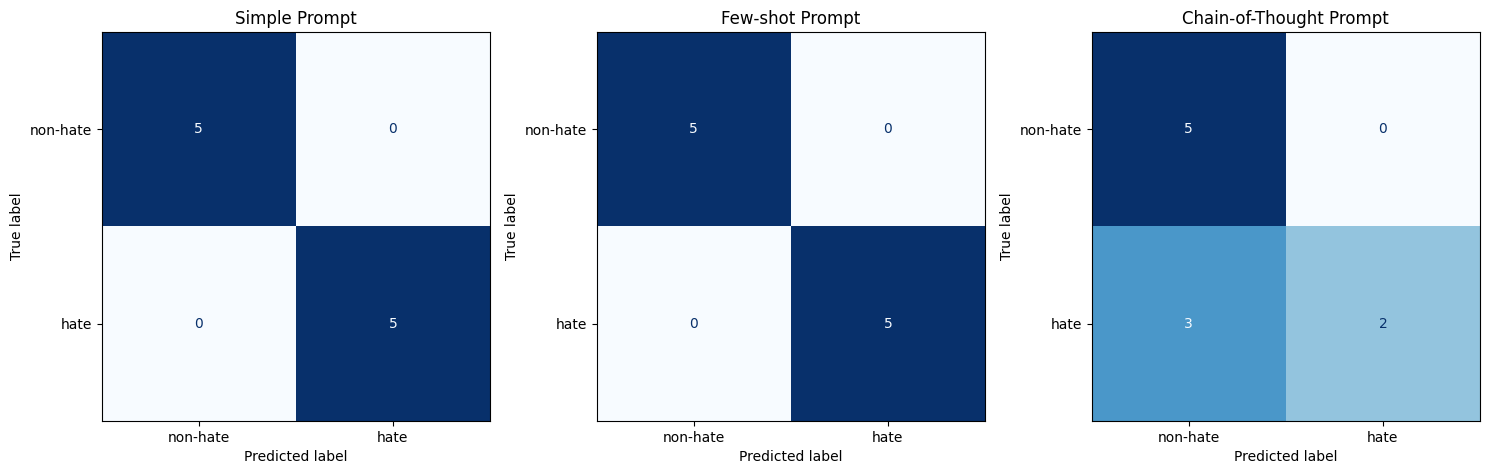

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_conf_matrix(ax, y_true, y_pred, title, labels=['non-hate', 'hate'], cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, colorbar=False, cmap=cmap)
    ax.set_title(title)

# Set up the plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot each confusion matrix 
plot_conf_matrix(axs[0], comp_df['true_label'], comp_df[f'pred_zero_{LLM_BACKEND}'], 'Simple Prompt')
plot_conf_matrix(axs[1], comp_df['true_label'], comp_df[f'pred_few_shot_{LLM_BACKEND}'], 'Few-shot Prompt')
plot_conf_matrix(axs[2], comp_df['true_label'], comp_df[f'pred_cot_{LLM_BACKEND}'], 'Chain-of-Thought Prompt')

plt.tight_layout()
plt.show()



# 5. Evaluation

In [ ]:
results_df = pd.DataFrame(results)

results_df